# Load AEM inversion results

In [23]:
import numpy as np
import pandas as pd
import dill
import matplotlib.pyplot as plt
from types import SimpleNamespace

## Load `.pik` `.csv` files 

In [25]:
input_data_dict = dill.load(open("./deliverables_kansas/input_gmd_4.pik", "rb"))
inp = SimpleNamespace(**input_data_dict)
thicknesses = inp.thickness
hz = np.r_[thicknesses, thicknesses[-1]]
n_sounding = inp.topography.shape[0]
df_collar = pd.read_csv("./deliverables_kansas/collar.csv")
line = df_collar['line_no'].values

inversion_results_sharp = dill.load(open("./output/inversion_results_sharp_precond_comp.pik", "rb"))
inversion_results_smooth = dill.load(open("./output/inversion_results_smooth_precond.pik", "rb"))
inversion_iterations = list(inversion_results_sharp.keys())
n_time = len(inp.times_ch1) + len(inp.times_ch2)

## Extract resistivity at certain iterations

In [26]:
iteration = 20
dpred_inv = -(inversion_results_sharp[iteration]['dpred'])
DPRED = dpred_inv.reshape((n_sounding, n_time))
dpred_ch1 = DPRED[:,:len(inp.times_ch1)]
dpred_ch2 = DPRED[:,len(inp.times_ch1):]
m_sharp = inversion_results_sharp[iteration]['m']
m_smooth = inversion_results_smooth[5]['m']
rho_smooth = 1./np.exp(m_smooth)
rho_sharp = 1./np.exp(m_sharp)

In [27]:
phi_d = []
phi_m = []
iterations = list(inversion_results_sharp.keys())
for iteration in iterations:
    phi_d.append(inversion_results_sharp[iteration]['phi_d'])
    phi_m.append(inversion_results_sharp[iteration]['phi_m'])

/var/folders/4m/sc07bkn154s8jfc7xp164by00000gq/T/ipykernel_41569/3956047070.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels)


Text(0, 0.5, 'Counts')

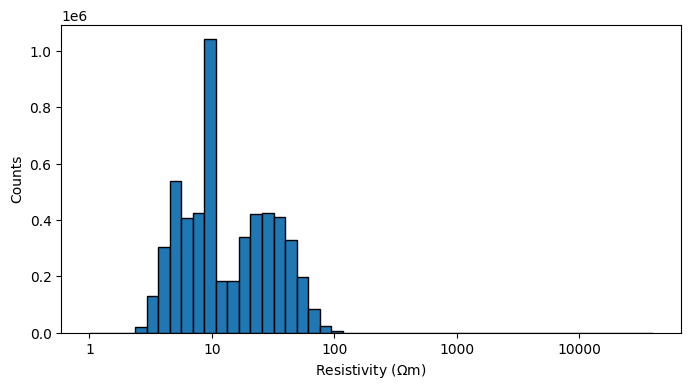

In [28]:
fig, ax = plt.subplots(1,1, figsize=(8, 4))
out = plt.hist(np.log10(rho_smooth), bins=np.linspace(np.log(1), np.log(100)), edgecolor='k')
ax.set_xlabel("Resistivity ($\Omega$m)")
xticks = ax.get_xticks()
xtick_labels = [f"{10**x:.0f}" for x in xticks]
ax.set_xticklabels(xtick_labels)
ax.set_ylabel("Counts")

## Look at the L-curve 

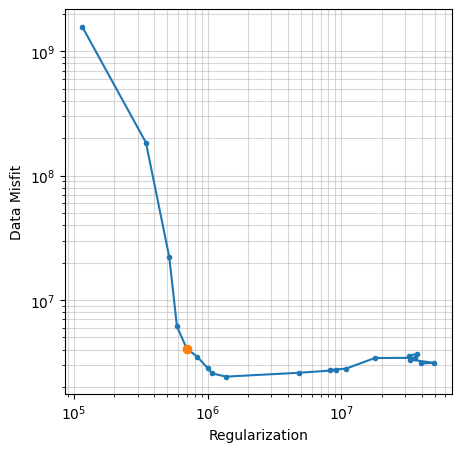

In [29]:
iteration = 5
fig = plt.figure(figsize=(5,5))
plt.loglog(phi_m, phi_d, '.-')
plt.loglog(phi_m[iteration-1], phi_d[iteration-1], 'o')
plt.xlabel("Regularization")
plt.ylabel("Data Misfit")
plt.grid(True, which='both', alpha=0.5)

## Create `.csv` files inverted resistivity values

In [31]:
columns = df_collar[['line_no', 'utmx', 'utmy', 'elevation']]
record = np.array(list(df_collar.index))

In [32]:
depth = np.r_[0., np.cumsum(hz)]
top = depth[:-1]
bottom = depth[1:]

In [33]:
TOP = np.tile(top, (n_sounding, 1))
BOTTOM = np.tile(bottom, (n_sounding, 1))

In [34]:
RHO_SMOOTH = rho_smooth.reshape((n_sounding, len(hz)))
RHO_SHARP = rho_sharp.reshape((n_sounding, len(hz)))

In [35]:
data_smooth = np.c_[record, columns, TOP, BOTTOM, RHO_SMOOTH]
data_sharp = np.c_[record, columns, TOP, BOTTOM, RHO_SHARP]

In [36]:
names_top = [f'top_{ii+1}_layer_m'for ii in range(len(hz))]
names_bottom = [f'bottom_{ii+1}_layer_m'for ii in range(len(hz))]
names_rho = [f'rho_{ii+1}_layer_m'for ii in range(len(hz))]

In [37]:
header_smooth = ['record', 'line_no', 'utmx', 'utmy', 'elevation']+ names_top + names_bottom + names_rho
header_sharp = ['record', 'line_no', 'utmx', 'utmy', 'elevation']+ names_top + names_bottom + names_rho

In [38]:
df_smooth = pd.DataFrame(data=data_smooth, columns=header_smooth)
df_sharp = pd.DataFrame(data=data_sharp, columns=header_sharp)

In [39]:
df_smooth.to_csv("deliverables/rho_smooth.csv", index=False)

In [40]:
df_sharp.to_csv("deliverables/rho_sharp.csv", index=False)